# Optical illusions

I've stumbled across the quite cool Youtube video below that is about an optical illusion that is very easy to reproduce just printing a copuple of images.

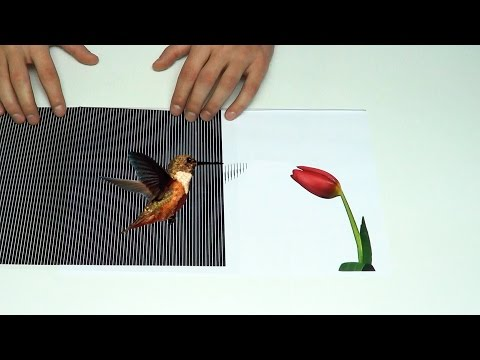

In [1]:
from IPython.lib.display import YouTubeVideo

YouTubeVideo('RBgeKdVHWCs')

The idea seems to be quite simple. 

The first image can be obtained by taking every frame of an animation, cutting it into  vertical stripes, *interleaving* the stripes and sticthing them together.

The second image is essentialy a *mask* obained using the same approach, starting from an animation with the same number of frames of the original one, but made with a white frame, followed by black frames.

By *interleaving* I mean that once you have sliced the $N$ frames, you create a first block of stripes taking stripe $0$ from the first frame, then stripe $1$ from the second frame and so on so forth up to stripe $N-1$ from the last frame; then you start the second block of stripes by taking stripe $N$ from the first frame, stripe $N+1$ from the second frame and so on. Finally you stitch the blocks together.

The [source notebook](https://github.com/mapio/OpticalIllusions) is available on GitHub (under [GPL v3](https://www.gnu.org/licenses/gpl-3.0.en.html)), feel free to use [issues](https://github.com/mapio/OpticalIllusions/issues) to point out errors, or to [fork it](https://help.github.com/articles/fork-a-repo/) to suggest edits.


## A simple example

Let's try to make it more clear with an example. Consider an animation with three frames, containing the first capital letters of the alphabet suitably colored.

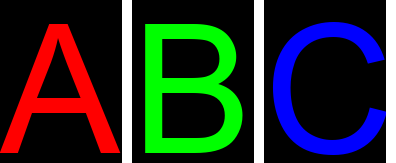

In [2]:
from PIL import Image, ImageFont, ImageDraw
import numpy as np

font = ImageFont.truetype('Arial.ttf', size = 180)
size = font.getsize('A')

def rasterize(letter, rgb):
    img=Image.new('RGB', size, (0, 0, 0))
    draw = ImageDraw.Draw(img)
    draw.text((0, -10), letter, rgb, font)
    draw = ImageDraw.Draw(img)
    return np.array(img)

def show(images):
    images = list(Image.fromarray(i) for i in images)
    widths = np.cumsum([0,] + list(map(lambda _: 10 + _.size[0], images)))
    height = images[0].size[1]
    result = Image.new('RGB', (widths[-1], height), (255, 255, 255))
    for idx in range(len(images)):
        result.paste(im = images[idx], box = (widths[idx], 0))
    return result
 
frames = [ 
    rasterize('A', (255, 0, 0)),
    rasterize('B', (0, 255, 0)),
    rasterize('C', (0, 0, 255))
]

show(frames)

To define the function performing the interleaving we'll use quite a few tricks. 

First of all, given the `width` of the stripes, we generate the indexes where we want to slice the frames.

In [3]:
width = 21

splits = range(width, frames[0].shape[1], width)

list(splits)

[21, 42, 63, 84, 105]

Then, using `numpy.hsplit` we cut every frame in a list of stripes. For example, for the first frame we get

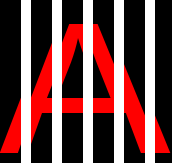

In [4]:
show(np.hsplit(frames[0], splits))

For the $k$-th frame, we keep just one stripe every `len(frames)`, that is we use `[k::len(frames)]` to index the list of stripes of frame $k$. We collect all such list of stripes in a list.

In [5]:
stripes = [np.hsplit(f, splits)[k::len(frames)] for k, f in enumerate(frames)]

Again, for the first frame, we keep just the first and fourth stripes

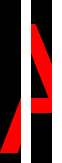

In [6]:
show(stripes[0])

Once we have such a list we `zip` it and use `numpy.hstack` to stitch together one stripe per frame obaining blocks of $N$ stripes each, finally we again use `numpy.hstack` to stitch every block together.

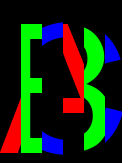

In [7]:
result = np.hstack(np.hstack(s) for s in zip(*stripes))

show([result])

We are ready to put together our tricks.

In [8]:
def interleave(frames, width):
    splits = range(width, frames[0].shape[1], width)
    return np.hstack(np.hstack(s) for s in zip(*(np.hsplit(f, splits)[k::len(frames)] for k, f in enumerate(frames))))

Let's test it with a smaller width

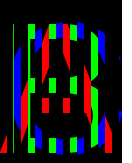

In [9]:
result = interleave(frames, 7)
show([result])

It's easy to note that there is no overlap among frames; since we have choosen red, green and blue, we can watch at a channel at a time to check this

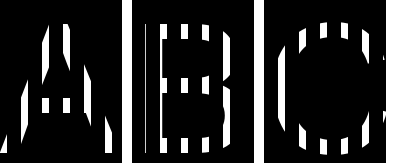

In [10]:
show([result[:,:,c] for c in range(3)])

## A more realistic example

To produce a more interesting result, let's start from an animated GIF; we need first of all to extract the frames.

In [11]:
def extract_frames(path):
    result = []
    frame = Image.open(path)
    n = 0
    while frame:
        result.append(np.array(frame.convert("RGB")))
        n += 1
        try:
            frame.seek(n)
        except EOFError:
            break
    return result

As an example, I choose a waling duck.

In [12]:
from IPython.display import HTML

HTML('<img src="duck.gif" style="width: 200px">')

Since such GIF contains too many frames and every frame has a lot of white space around the main subject, we pick a frame every 3 and crop it.

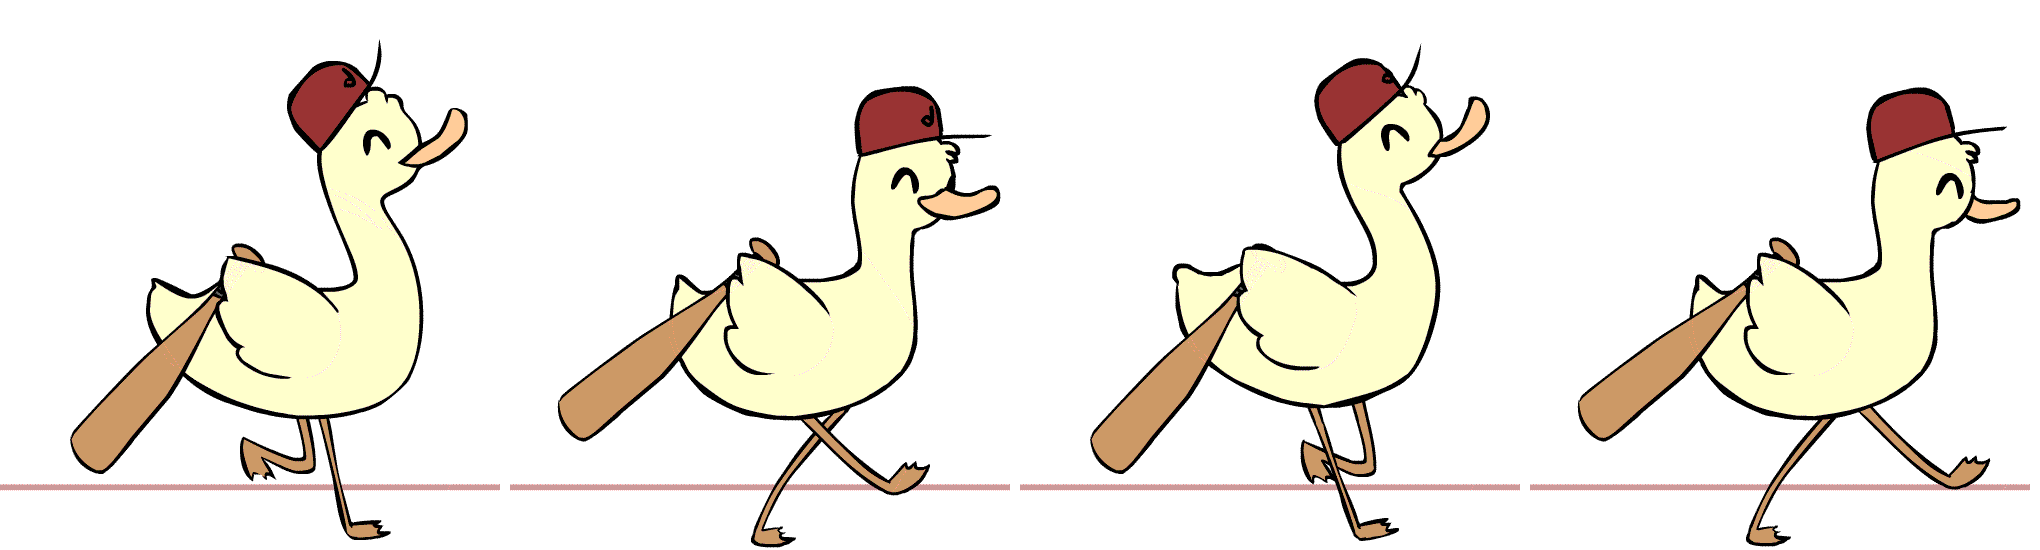

In [13]:
frames = [f[100:650,300:800,:] for f in extract_frames('duck.gif')[::3]]
show(frames)

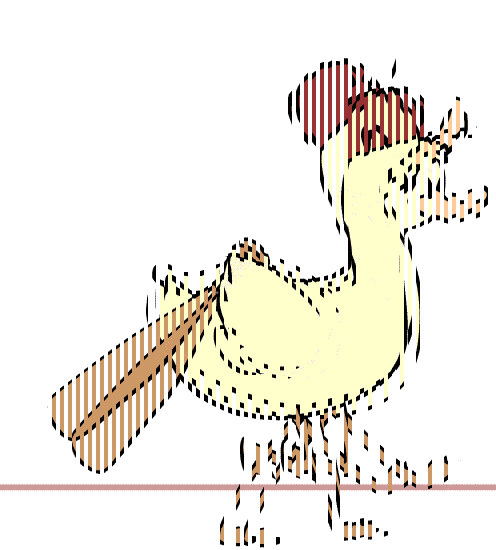

In [14]:
width = 4

img = Image.fromarray(interleave(frames, width))
img.save('duck-i.png')
img

### The mask

As promised, generating the mask is quite easy, you just need a white and a black frames.

In [15]:
white = (255 * np.ones(frames[0].shape)).astype(np.uint8)
black = np.zeros(frames[0].shape).astype(np.uint8)

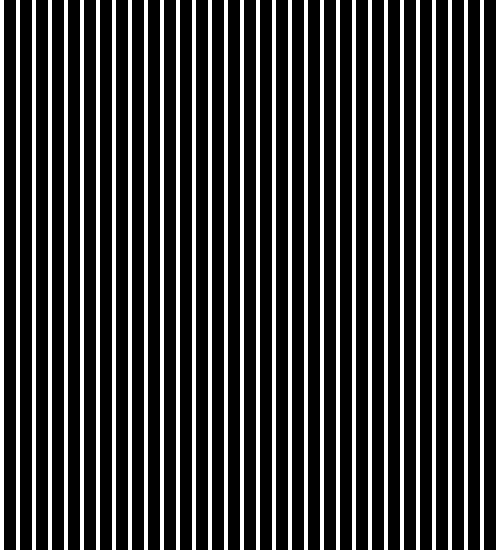

In [16]:
mask = Image.fromarray(interleave([white, ] + [black for _ in range(len(frames) - 1)], width))
mask.save('mask.png')
mask

You can now print the two images and try if it works!